# Introduction

The real estate sector in Rwanda has grown tremendously in recent years. In 2019 alone this sector contributed  to the national GDP around 647 Billion Rwandan Francs._[(RDB)](https://rdb.rw/investment-opportunities/real-estates/#:~:text=The%20real%20estate%20sector%20is,private%20constructions%20and%20public%20works.)_ Not only real estate developers but also other people are either selling or buying houses. Sometimes these people don't know the price their can tag to the house they are selling or those with specifications and neighborhood of their dream homes don't know how much they can cost them.
This projects uses the data I collected (Web Scrapped) from a website that list the houses for sale in Rwanda, and employs machine learning to predict the price of a house given its neighborhood, plot size, number of bedrooms and bathrooms, etc.

# The Datasets & Modules

As mentioned in the introduction, this project uses the data I scrapped from the web. The datasets has these columns:

- Price: The price tag alongside the currency
- Location: The area where the house is located
- Size: The size of the plot alongside the unit of measurements
- Bedrooms: The number of bedrooms
- Bathrooms: The number of bathrooms
- Wardrobes: Whether the bedrooms have built-in wardrobes
- Cabinets: Whether the kitchen has the cabinets
- Balcony: Whether the house has the balcony
- Parking: Whether the house has parking
- Quarters: Whether the house has the boys quarters/annexes

**Pandas, Numpy and Regular expressions** modules are used for data cleaning, **Pandas_profiling, Matplotlib, Pywaffle and Seabon** for data explorations and visualiations, and **Sci-kit Learn and Gradient extreme boosting (xgboost)** for machine learning.

# Exploring the Data & Preprocessing

With the help of summary tables and some visuals, the missing values, number of records, ... are unrevealed through this step.

## Overview

In [1]:
#Importing important libraries
import warnings
import matplotlib.pyplot as plt
from pywaffle import Waffle
import seaborn as sns
import re
import pandas as pd
import pandas_profiling as pp
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.min_rows = 20
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
# Reading & Inspecting the Dataset
houses = pd.read_csv('kigali houses.csv')
pp.ProfileReport(houses)

In [3]:
houses.sample(10)

,Price,Location,Size,Bedrooms,Bathrooms,Wardrobes,Cabinets,Balcony,Parking,Quarters
4256,85 000 000 Rwf,"Kimironko house for sale, 4 bedrooms, price:85 millions",/,4.0,3.0,NaN,NaN,NaN,NaN,NaN
1984,55 000 000 Rwf,www.kigalidealer.com,20/25,4.0,3.0,NaN,NaN,NaN,NaN,NaN
2828,140 000 000 Rwf,"Kigali, Kimironko",NaN,4.0,4.0,Yes,Yes,Yes,Yes,NaN
204,50 000 000 Rwf,"kicukiro, house for sale @50.000.000 Rwf",25/30m,4.0,3.0,NaN,NaN,NaN,Yes,Yes
2352,100 000 000 Rwf,100M kibagabaga,/,4.0,3.0,NaN,Yes,NaN,NaN,NaN
3433,30 000 000 Rwf,30M GIKONDO,20mx30m,4.0,3.0,NaN,NaN,NaN,NaN,NaN
974,150 000 000 Rwf,kibagabaga house for sale @ 150 millions,35/30m,6.0,4.0,NaN,NaN,NaN,Yes,Yes
4241,32 000 000 Rwf,32M KABEZA,/,4.0,3.0,NaN,Yes,NaN,NaN,NaN
10,150 000 000 Rwf,Kimironko:kivuproperty.com,25mx30m,4.0,3.0,NaN,NaN,NaN,NaN,NaN
239,200 000 000 Rwf,200M Gikondo,30mx40m,8.0,6.0,NaN,NaN,NaN,NaN,NaN


In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4799 entries, 0 to 4798
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      4799 non-null   object 
 1   Location   4799 non-null   object 
 2   Size       4105 non-null   object 
 3   Bedrooms   4270 non-null   float64
 4   Bathrooms  4510 non-null   float64
 5   Wardrobes  1021 non-null   object 
 6   Cabinets   1466 non-null   object 
 7   Balcony    1074 non-null   object 
 8   Parking    3220 non-null   object 
 9   Quarters   2820 non-null   object 
dtypes: float64(2), object(8)
memory usage: 375.0+ KB


In [5]:
houses.nunique(dropna=False)

Price         165
Location     1253
Size          279
Bedrooms       15
Bathrooms      11
Wardrobes       2
Cabinets        2
Balcony         2
Parking         2
Quarters        2
dtype: int64

> The dataset has 10 columns and 4799 records. Some of the columns have null values with the availability of balcony, built-in wardrobes and cabinets in the kitchen having too many missing values. The `Location` column is the more diversed one. Based on what is shown on the sample this column require much cleansing to have harmonized location names. Only `Bedrooms` and `Bathrooms` columns are so far the numerical form which means that the `Price` and `Size` columns should be converted into numbers as well.

## Visualizing missing values

The below section visualizes the distribution of missing values before cleaning.

In [6]:
def plot_missing_values(df):
    """
    Shows the distribution of the non-missing vs mising values.
    """
    plt.figure(figsize=(10, 5))
    plt.title('Distribution of Missing Values')
    sns.heatmap(df.isnull(), cbar=False)

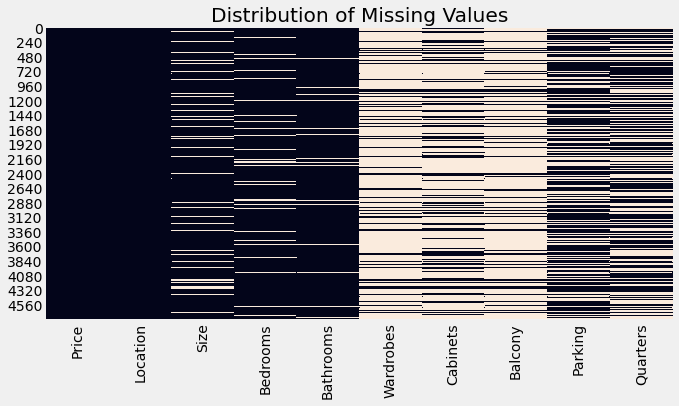

In [7]:
plot_missing_values(houses)

> Many houses were listed without mentioning the plotsize, wardrobes, cabinets, balcony, parking and boys' quarters.

## Preprocessing

As seen in our sample, even our target column `Price` is not numeric. The first thing is to separate the value with the currency and do the exchange in Rwandan Francs. In the last two years the $1 on average was around 950 RWF. _([ER](https://www.exchangerates.org.uk/USD-RWF-exchange-rate-history.html))_ This value will be used to convert the USD to RWF. The second column which need cleansing is the `Size`. Mostly it is shown as width by height or width x height followed by the unit of length (m) or the calculated area followed by the square meters (sqm). Lastly, the location column need to be cleaned as well. There are somewhere the `Location` is mixed with some digits representing the price in Million. There are also many redundancies where some variations of a location such as Kigali-Remera, Remera Kigali, Remera all meant Remera. Again, where the name of the district is followed by the sector name or any lower level, the name of the lower level should one be the one to be considered.

In [8]:
def calculate_price(price):
    """
    Returns the price of the house in Rwandan Francs by separating it with the currency and do conversion where necessary.
    """
    price_regex = r'([\d\s]+)'
    currency_regex = r'([a-zA-Z$]+)'
    currency = re.findall(currency_regex, str(price))
    price = re.findall(price_regex, str(price))
    exchange = 950
    
    if len(currency) > 0 and currency[0].lower() == 'rwf':
        return int(price[0].replace(' ',''))
    elif len(currency) > 0 and currency[0].lower() == '$':
        return int(price[0].replace(' ',''))*exchange
    else:
        return np.nan

In [9]:
houses['Final Price'] = houses['Price'].apply(calculate_price)

In [10]:
def calculate_area(plotsize):
    """
    Returns the area of the house in square meters (sqm).
    """
    sizes_regex = r'(\d+)'
    sizes = re.findall(sizes_regex, str(plotsize))
    
    if len(sizes) == 2:
        return int(sizes[0])*int(sizes[1])
    elif len(sizes) == 1:
        return sizes[0]
    else:
        return np.nan

In [11]:
houses['Plot Area'] = houses['Size'].apply(calculate_area)

In [12]:
def get_location(location):
    """
    Returns a lowest possible level of the location after removing any link, digits,
    and other words which are not location names.
    """
    location_regex = r'\b^\d+[a-z]+\b|(@?\d+.*)$|\bis\b|\bin\b|\ba\b|f[op]r|sale|villas?|very|joseph|\bheza\b|quartier|big|nice|ahantu|\bkwa\b|\bat\b|near|\bna\b|\bon\b|\bto\b|main|road|street|\bhafi\b|\bthe\b|kuri|selling|a?houses?|urenze|\bku\b|nganda|zone|city|sector|office|rwanda|munini|[ky]?umuhanda|w?amabuye|hospital|closer|paved|tarmac|kariyeri|kaburimbo|nego[tc]iable|https|@?festus|peter|([a-z]{3}\.)?[a-z]*[\.,]com|homeland.rw|kivu manu dael|downtown|rent'
    cleaned_location = re.sub(location_regex,'',location.lower()).title().strip()
    possible_regex = '\W'
    possible_locations = re.split(possible_regex,cleaned_location)
    possible_locations = [x for x in possible_locations if x]
    
    if len(possible_locations) > 1:
        for location in ['Kigali', 'Gasabo', 'Kicukiro', 'Nyarugenge']:
            if len(possible_locations) == 1:
                break
            if location in possible_locations:
                possible_locations.remove(location)
                
    if (len(possible_locations) == 1) & ('Kigali' not in possible_locations):
        return possible_locations[0]
    
    elif len(possible_locations) >= 2:
        return possible_locations[1]
    
    else:
        return np.nan

In [13]:
houses['New Location'] = houses['Location'].apply(get_location)
houses['New Location'].value_counts().head(40)

Kanombe        814
Kibagabaga     658
Kimironko      524
Kicukiro       423
Gacuriro       216
Gisozi         168
Kabeza         158
Kagarama       117
Remera         104
Masaka         101
Gikondo        100
Kabuga          99
Nyarutarama     64
Kagugu          53
Nyamata         50
Kacyiru         43
Kinyinya        35
Kiyovu          34
Kimihurura      27
Zindiro         27
Nyamirambo      25
Niboyi          23
Rebero          20
Gahanga         18
Gasogi          15
Karuruma        15
Rusororo        15
Gatenga         13
Muyumbu         12
Gasanze         12
Karumuna        12
Gasabo          11
Ndera           11
Kibagaba        10
Ruyenzi         10
Rdb             10
Kimiromko        8
Rugende          8
Fawe             7
Niboye           7
Name: New Location, dtype: int64

> Some locations are again related or in same neighborhoods for example both Fawe and Gaposho are in Gisozi therefore can be mapped to it.

In [14]:
neighborhoods = {'Fawe':'Gisozi','Gaposho':'Gisozi', 'Niboye':'Niboyi','Kibagaba':'Kibagabaga','Kimiromko':'Kimironko',
                 'Rusororo':'Kabuga/Ndera/Rusororo','Ndera':'Kabuga/Ndera/Rusororo', 'Kabuga':'Kabuga/Ndera/Rusororo',
                 'Murindi':'Kabuga/Ndera/Rusororo', 'Gasogi':'Kabuga/Ndera/Rusororo', 'Rdb':'Nyarutarama', 'Niboye':'Niboyi',
                 'Kibagababa':'Kibagabaga', 'Gishushu':'Nyarutarama','Masizi':'Zindiro', 'Karembure':'Gahanga',
                'Gatenga':'Gatenga/Gikondo','Gikondo':'Gatenga/Gikondo','Kibagaba':'Kibagabaga'}

houses['Neighborhood'] = houses['New Location'].replace(neighborhoods)

> Some neighborhoods doesn't have enough listings so the rest of the project only those with at least 20 listing.

In [15]:
plus20_listings = houses['Neighborhood'].value_counts()[houses['Neighborhood'].value_counts().values >= 20].index
plus20_listings

Index(['Kanombe', 'Kibagabaga', 'Kimironko', 'Kicukiro', 'Gacuriro', 'Gisozi',
       'Kabeza', 'Kabuga/Ndera/Rusororo', 'Kagarama', 'Gatenga/Gikondo',
       'Remera', 'Masaka', 'Nyarutarama', 'Kagugu', 'Nyamata', 'Kacyiru',
       'Kinyinya', 'Kiyovu', 'Zindiro', 'Niboyi', 'Kimihurura', 'Nyamirambo',
       'Gahanga', 'Rebero'],
      dtype='object')

In [16]:
#Removing the houses that has the neighborhood as Nyamata and Kigali Neighborhoods
plus20_listings = [neighborhood for neighborhood in plus20_listings if neighborhood not in ['Nyamata']]
houses = houses[houses.Neighborhood.isin(plus20_listings)]

## Dealing with missing values & outliers

Now that most of our columns are cleaned, we can remove rows with many missing values. Some extreme values will be treated or removed as well.

- Because the `Parking` and `Quarters` are Categorical with either Yes/No and we know that each with NaN didn't mention to have it. We can fill their Missing Values with No.

- Even though the Government of Rwanda's rules and regulations set the standard plot size as 300 square meters.[(Igihe)](https://en.igihe.com/news/government-sets-new-acceptable-standards-for-plot#:~:text=The%20order%20stipulates%20that%20the,not%20go%20beyond%20one%20hectare.) This value is not used to fill the NaN values in the Plot `Size` because most of the time the plot size highly correlates with the price of a house.

- No one would really build a house with No or 0 bedrooms. These records alongside with those with Missing Plot size will be removed.

In [17]:
houses['Parking'].fillna('No',inplace = True)
houses['Quarters'].fillna('No',inplace = True)
houses['Wardrobes'].fillna('No',inplace = True)
houses['Balcony'].fillna('No',inplace = True)
houses['Cabinets'].fillna('No',inplace = True)
houses.dropna(inplace=True) # Removing any records with NaN value

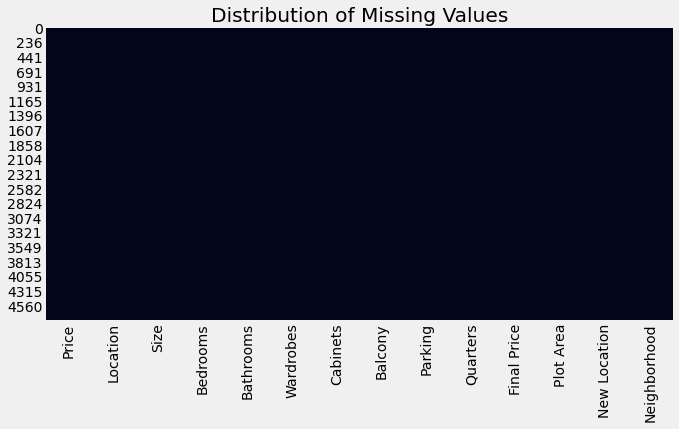

In [18]:
#Checking if non missing values
plot_missing_values(houses)

Now that we have no missing values let's remove some outliers. 

- For residential houses it is unusual to find a house with more than 10 bedrooms or bathrooms.
- According to the Institute of Real Property Valuers in Rwanda, IRPV's [Land Price Reference Prices](https://www.irpv.rw/download/LAND%20REFERENCE%20PRICES.pdf) and [Crops and Construction Reference Prices](https://www.irpv.rw/download/CROPS%20AND%20CONSTRUCTION%20REFERENCE%20PRICES.pdf) it is clear that a house with standard plot size can be valued under 15,000,000 Rwf. Therefore the house with Price less this amount will be removed.
- The other outliers in Price and Area columns will be removed using the [1.5 Interquartile Range Rule](https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244#:~:text=Add%201.5%20x%20(IQR)%20to,this%20is%20a%20suspected%20outlier.) where the values below the 1.5 times the Interquartile Range below the first quartile or above the third quartile are considered as outliers.
- Talking about standard in upcoming days no one will built or buy a house with a plotsize less than recommended standards. The records with Area less than 300 will be removed as well.

In [19]:
houses = houses[houses['Plot Area'].astype(int) >= 300]
houses = houses[houses['Final Price'].astype(int) >= 15000000]
houses = houses[(houses['Bedrooms'] <= 10) & (houses['Bathrooms'] <=10) & (houses['Bedrooms'] > 0) & (houses['Bathrooms']>0)]

In [20]:
def calculate_outliers_bounds(df,column):
    """
    Returns the lower and upper bounds for determining outliers using the 1.5 Interquartile Range Rule.
    """
    q25, q75 = np.percentile(df[column].astype(int), 25), np.percentile(df[column].astype(int), 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
    
    return lower_bound, upper_bound

In [21]:
lower_price, upper_price = calculate_outliers_bounds(houses,'Final Price')
lower_area, upper_area = calculate_outliers_bounds(houses, 'Plot Area')
print(f'The lower bound for the Plot Area is: {lower_area}')
print(f'The upper bound for the Plot Area is: {upper_area}')
print('==============')
print(f'The lower bound for the Price is: {lower_price}')
print(f'The upper bound for the Price is: {upper_price:,}')

The lower bound for the Plot Area is: 375.0
The upper bound for the Plot Area is: 975.0
The lower bound for the Price is: -10000000.0
The upper bound for the Price is: 150,000,000.0


> The houses with a plotsize between 375 and 975 sqm and those with a price not greater than 150 Million are kept.

In [22]:
houses = houses[(houses['Final Price'].astype(int) <= upper_price) & (houses['Plot Area'].astype(int) <= upper_area) &
                (houses['Plot Area'].astype(int) >= lower_area)]

In [23]:
len(houses['Plot Area'].value_counts())

34

## Reprocessing the Area column.

This column has now 34 unique values ranging between 375 and 975. This means that some values such as 375 and 380 might be considered very differently during our modeling. Let's harmonize further this column by setting up categories.

In [24]:
def process_Area(df):
    """
    Process the Plot Area column into categories 
    """
    cut_points = [300,399,499,599,699,799,899,999]
    categories = [1,2,3,4,5,6,7]
    df['Plot Category'] = pd.cut(df['Plot Area'].astype(int),cut_points,labels=categories)
    
    return df

In [25]:
houses = process_Area(houses)

## Visualizing the share of houses by number of bedrooms & bathrooms

Number of bedrooms and bathrooms also contribute much to the Price of a house. Even though these columns are cleaned, let visualize further to see if theren't those which are underrepresented.

In [26]:
bedrooms = dict((houses['Bedrooms'].value_counts(normalize=True)*100).sort_index())
bathrooms = dict((houses['Bathrooms'].value_counts(normalize=True)*100).sort_index())
colors = ['yellow','orange','red', 'green', 'blue', 'purple', 'crimson','darkviolet','navy','cyan']
bed_colors = [colors[int(key)] for key in bedrooms.keys()]
bath_colors = [colors[int(key)] for key in bathrooms.keys()]

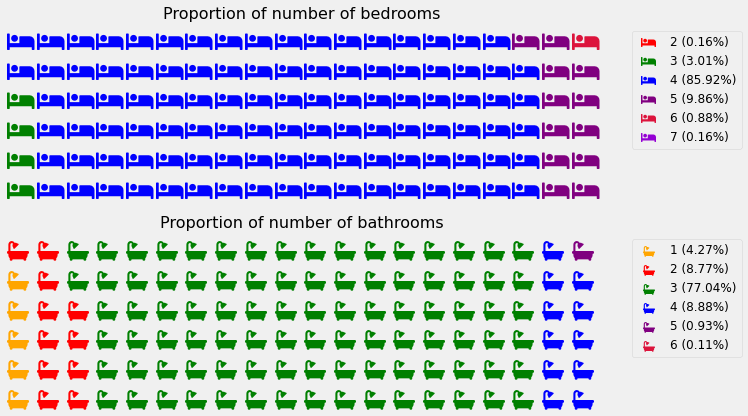

In [27]:
plt.figure(figsize=(15,6), FigureClass=Waffle, 
    plots={'211': {'values': bedrooms, 'icons':'bed', 'colors':bed_colors,
            'labels' : ["{:.0f} ({:.2f}%)".format(value, percentage) for value, percentage in bedrooms.items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':12},
            'title': {'label': 'Proportion of number of bedrooms', 'loc': 'center', 'fontsize':16}},
           '212': {'values': bathrooms, 'icons':'bath', 'colors':bath_colors,
            'labels' : ["{:.0f} ({:.2f}%)".format(bathrooms, percentage) for bathrooms, percentage in bathrooms.items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':12},
            'title': {'label': 'Proportion of number of bathrooms', 'loc': 'center', 'fontsize':16}},
          },
           rows=6, columns = 20, font_size=22, icon_legend=True)   
plt.show()

> Until now our dataset is dominated by houses with 3-5 bedrooms and 1-4 bathrooms. The final dataset will have only these records.

In [28]:
houses = houses[houses['Bedrooms'].isin(range(3,6)) & houses['Bathrooms'].isin(range(1,5))]

# Features and Target Preparation

So far the records which contained redundant information and vague information are cleansed. It is now the time to apply different machine learning algorithms. But before that we have to prepare all our features of interest to be in numerical form. The non numerical columns  `Parking`, `Balcony`, `Wardrobes`, `Cabinets`, `Neighborhood` and `Plot Category` are encoded as dummy variables so that they can be used in modeling combined with the `Bathrooms` and `Bedrooms` columns which are in numerical form. The target column (`Final Price`) remains in the numerical form of course.

In [29]:
houses.columns

Index(['Price', 'Location', 'Size', 'Bedrooms', 'Bathrooms', 'Wardrobes',
       'Cabinets', 'Balcony', 'Parking', 'Quarters', 'Final Price',
       'Plot Area', 'New Location', 'Neighborhood', 'Plot Category'],
      dtype='object')

In [30]:
def process_features(df, numerical, dummies):
    """
    Returns the features dataset after joining the dummy columns to the numerical columns
    """
    dummy_cols = pd.get_dummies(df[dummies])
    features = pd.concat([df[numerical],dummy_cols],axis=1)
    
    return features

In [31]:
dummies = ['Wardrobes','Cabinets', 'Balcony', 'Parking', 'Quarters','Neighborhood', 'Plot Category']
numerical = ['Bedrooms', 'Bathrooms']

features, target = process_features(houses, numerical, dummies), houses['Final Price']

In [32]:
features.head(5)

,Bedrooms,Bathrooms,Wardrobes_No,Wardrobes_Yes,Cabinets_No,Cabinets_Yes,Balcony_No,Balcony_Yes,Parking_No,Parking_Yes,Quarters_No,Quarters_Yes,Neighborhood_Gacuriro,Neighborhood_Gahanga,Neighborhood_Gatenga/Gikondo,Neighborhood_Gisozi,Neighborhood_Kabeza,Neighborhood_Kabuga/Ndera/Rusororo,Neighborhood_Kacyiru,Neighborhood_Kagarama,Neighborhood_Kagugu,Neighborhood_Kanombe,Neighborhood_Kibagabaga,Neighborhood_Kicukiro,Neighborhood_Kimihurura,Neighborhood_Kimironko,Neighborhood_Kinyinya,Neighborhood_Kiyovu,Neighborhood_Masaka,Neighborhood_Niboyi,Neighborhood_Nyamirambo,Neighborhood_Nyarutarama,Neighborhood_Rebero,Neighborhood_Remera,Neighborhood_Zindiro,Plot Category_1,Plot Category_2,Plot Category_3,Plot Category_4,Plot Category_5,Plot Category_6,Plot Category_7
0,4.0,1.0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4.0,3.0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,4.0,1.0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
10,4.0,3.0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
14,4.0,3.0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [33]:
target.head(5)

0      55000000.0
2      45000000.0
7      22000000.0
10    150000000.0
14     50000000.0
Name: Final Price, dtype: float64

# Performance Metrics and Train-Test Spiliting

## The performance metrics

Our target variable is a continuous value which makes our problem a regression problem. One might be interested in seeing the difference between the predicted value and the actual value. This can be achieved using the mean absolute error **(MAE)** which shows on average how much the predicted value is above or below the actual value. On the other hand the **R-Squared** is used to see how good the model fit our data.

In [34]:
from sklearn.metrics import mean_absolute_error, r2_score

## The training and test datasets

80% of the data is used for training and the remaining for evaluating the performance of our models.

In [35]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_target, test_target = train_test_split(features, target,test_size=.2, random_state=1)

# Modeling and Making Predictions

The below helper function will help to train, make predictions and evaluate the performance of the model using the evaluation metrics stated above.

In [36]:
def train_predict_evaluate(model,name):
    """
    Train, predict and evaluate the performance of the model.
    """
    model.fit(train_features, train_target)
    predicted = model.predict(test_features)
    mae = mean_absolute_error(test_target, predicted)
    r2 = r2_score(test_target, predicted)
    print(name)
    print('======================================')
    print(f'The Mean Absolute Error: {mae:,.2f}')
    print(f'The model fits {r2*100:.2f}% of the data')

## Linear Regression

The linear regression is the straight forward model as it usually considers the linearity between the features and the target. However, it is not the most accurate option.

In [37]:
from sklearn.linear_model import LinearRegression
train_predict_evaluate(LinearRegression(), 'Linear Regression')

Linear Regression
The Mean Absolute Error: 125,569,464,461,850,048.00
The model fits -786099108016341030797312.00% of the data


> The linear regression model has a poor performance. Probably there is no linear relationship between our features and the target.

## Kneighbors Regressor

The Kneighbors algorithm doesn't assume the linearity between the feature and the target. Therefore, this can perform well when features are not highly correlated with the target.

In [38]:
from sklearn.neighbors import KNeighborsRegressor
train_predict_evaluate(KNeighborsRegressor(), 'KNeighbors Regressor')

KNeighbors Regressor
The Mean Absolute Error: 12,839,106.15
The model fits 50.32% of the data


## Decision Tree Regressor

Due to the complexity of the Decision tree models, they tend to perform well compared to Linear and KNeighbors models. The only issue is that they can tend to overfit when not tweaked accordingly.

In [39]:
from sklearn.tree import DecisionTreeRegressor
train_predict_evaluate(DecisionTreeRegressor(random_state=1), 'Decision Tree Regressor')

Decision Tree Regressor
The Mean Absolute Error: 8,806,882.96
The model fits 68.77% of the data


## Random Forest Regressor

Random Forest models train several decision trees on randomly selected sub-samples and features hoping that combining the prediction of multiple models shall results in less error. Due to the way they are built they tend to be more accurate compared to linear models and more immune to overfitting compared to Decision tree models.

In [40]:
from sklearn.ensemble import RandomForestRegressor
train_predict_evaluate(RandomForestRegressor(random_state=1),'Random Forest Regressor')

Random Forest Regressor
The Mean Absolute Error: 9,528,827.14
The model fits 68.49% of the data


> The decision tree forest is so far the most performing model. As stated, the random forest train the decision trees in parallel (bagging). Below I am training the model which train the algorithm which in background train the decision trees in sequential manner by improving the previous trained trees the technique known as boosting.

## XGBOOST Regressor

As its name says this model uses the boosting techniques to improve the overall predictions.

In [41]:
from xgboost import XGBRegressor
train_predict_evaluate(XGBRegressor(),'XGBRegressor')

XGBRegressor
The Mean Absolute Error: 9,479,023.75
The model fits 66.22% of the data


# Features' selection, hyper parameters tuning and final modeling

## Selecting best-performing features

The baseline models are trained using all features. But we can try to see if there are some best-performing features and use them instead. This can help increasing the accuracy of our model and reduce the training time. The Recursive Feature Extraction Cross Validation is used below alongside the Decision tree and XGBoost regressor models to see if some features are more important than others. 

In [42]:
from sklearn.feature_selection import RFECV

In [43]:
def select_features(model,features, target):
    """
    Returns the features wich are important for the model.
    """
    selector = RFECV(model,cv = 5) #80% and 20% of the data being used for train & train respectively at each iteration
    selector.fit(features,target)
    optimized_columns = list(features.columns[selector.support_])
    
    return optimized_columns

In [44]:
#DecisionTree
model = DecisionTreeRegressor(random_state=1)
selected_features = select_features(model, features, target)
print(f'Total number of all features is {len(features.columns)}')
print(f'Total number of selected features is {len(selected_features)}')

Total number of all features is 42
Total number of selected features is 34


In [45]:
#XGBoost
model = XGBRegressor(random_state=1,n_jobs=-1)
selected_features = select_features(model, features, target)
print(f'Total number of all features is {len(features.columns)}')
print(f'Total number of selected features is {len(selected_features)}')

Total number of all features is 42
Total number of selected features is 34


> Our feature selection methods selected 34 of the 42 features. This means 34 features will be used to train the best performing model after hyper parameters tuning.

## Selecting the best-performing parameters and model

The grid search cross-validation method is used to find the best-performing model using any combination of different parameters provided.

The Random Forest and the Extreme Gradient Boosting models have the lower error. Therefore there are the ones considered in this step.

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
def select_model(model, hyperparameters, features, target):
    """
    Select the best performing hyperparameters combination
    """
    grid = GridSearchCV(model, param_grid = hyperparameters, cv = 5, 
                        scoring = 'neg_mean_absolute_error', n_jobs = -1)
    grid.fit(features, target)
    best_params = grid.best_params_
    best_score = grid.best_score_

    print('============')
    print(best_params)
    print(f'{best_score:,}')     

### Decision Tree Regressor hyper-parameters tuning

In [48]:
space = {}
space['criterion'] = ['mae','mse']
space['min_samples_leaf'] = [1,2,3]
space['max_depth'] = [None,3,5,7]
space['min_samples_split'] = [2,3]
space['max_features'] = [17,18,19]

In [49]:
select_model(DecisionTreeRegressor(random_state=1),space, features, target)

{'criterion': 'mae', 'max_depth': None, 'max_features': 17, 'min_samples_leaf': 1, 'min_samples_split': 2}
-9,558,592.710827347


In [50]:
train_predict_evaluate(DecisionTreeRegressor(random_state=1, criterion = 'mae', min_samples_leaf = 1, max_features=17),
                       'Decision Tree Regressor')

Decision Tree Regressor
The Mean Absolute Error: 8,615,921.79
The model fits 66.93% of the data


> 17 features are found to be the favorable features when looking for the best split.

### xgboost hyperparameters tuning

In [51]:
xgboost_space = {}
xgboost_space['max_depth'] = [16,18,19]
xgboost_space['min_child_weight'] = [5]
xgboost_space['learning_rate'] = [0.5,0.8,1]
xgboost_space['n_estimators'] = [55,60,65]
xgboost_space['gamma'] = [0.0]
xgboost_space['colsample_bytree'] = [1]
xgboost_space['min_samples_split'] = [1]
xgboost_space['min_samples_leaf'] = [1]

In [55]:
select_model(XGBRegressor(random_state=1,n_jobs=-1),xgboost_space, features, target)

[17:03:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'colsample_bytree': 1, 'gamma': 0.0, 'learning_rate': 0.5, 'max_depth': 19, 'min_child_weight': 5, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 65}
-9,832,923.436317544


In [53]:
train_predict_evaluate(XGBRegressor(random_state=1,learning_rate=0.5,min_child_weight=5, min_samples_leaf = 1,
                                   gamma = 0.0, colsample_bytree=1, min_sample_split = 1, max_depth = 19, n_estimators=65),'XGBRegressor')

[17:02:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_sample_split, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBRegressor
The Mean Absolute Error: 9,048,572.25
The model fits 68.80% of the data


> The tuned XGBRegressor doesn't outperform the decision tree regressor regarding the error. But it fits much of the data compared to decision tree. Given the fact that decision trees tend to overfit, an ensemble model such as the XGBRegressor is mostly preferred in production. Therefore the XGBRegressor will be trained and deployed.

## Saving the trained model

The last step in this project is to save the trained model for the later usage. The **Extreme Gradient Boosting Regressor** has a small error of around **13%** of the average target price. This model is saved using the **pickle** module serves the web application that allows anyone to enter the detail of the house and see its predicted price. The app can be found on this [link]()

In [54]:
import pickle
model = XGBRegressor(random_state=1,learning_rate=0.5,min_child_weight=5, min_samples_leaf = 1,
                                   gamma = 0.0, colsample_bytree=1, min_sample_split = 1, max_depth = 19, n_estimators=65)
model.fit(features[selected_features], target) #The final model is trained using all available data
with open('kigali houses model.sav','wb') as file:
    pickle.dump(model,file)

[17:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_sample_split, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




# Conclusion

The part of cleaning, explorating and building the machine learning model ends here. The error is somehow high but acceptable due to only few information provided when listing houses. I believe with more information such as the year in which the house was built, the type and quality of materials used for example on roofs, the size of the parking, whether it has floor/s or not, the distance to the main amenities such as city center, bus parks and main markets one can improve the performance of the model.


_Gaspard Nzasabimfura_

_Data Analyst, Scientist & Engineer_

_Email: nzagaspard@gmail.com_

_March 2021_


In [58]:
selected_features

['Bedrooms',
 'Bathrooms',
 'Wardrobes_No',
 'Cabinets_No',
 'Balcony_No',
 'Parking_No',
 'Quarters_No',
 'Neighborhood_Gacuriro',
 'Neighborhood_Gahanga',
 'Neighborhood_Gatenga/Gikondo',
 'Neighborhood_Gisozi',
 'Neighborhood_Kabeza',
 'Neighborhood_Kabuga/Ndera/Rusororo',
 'Neighborhood_Kacyiru',
 'Neighborhood_Kagarama',
 'Neighborhood_Kagugu',
 'Neighborhood_Kanombe',
 'Neighborhood_Kibagabaga',
 'Neighborhood_Kicukiro',
 'Neighborhood_Kimihurura',
 'Neighborhood_Kimironko',
 'Neighborhood_Kinyinya',
 'Neighborhood_Masaka',
 'Neighborhood_Niboyi',
 'Neighborhood_Nyamirambo',
 'Neighborhood_Nyarutarama',
 'Neighborhood_Rebero',
 'Neighborhood_Remera',
 'Plot Category_2',
 'Plot Category_3',
 'Plot Category_4',
 'Plot Category_5',
 'Plot Category_6',
 'Plot Category_7']